In [19]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5' 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from progressbar import ProgressBar
from sklearn.preprocessing import MinMaxScaler
import scipy

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# for SNGP
import gpflow
import gpflux
from gpflow.config import default_float

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

plt.rcParams.update({'font.size': 18})

## Load the Capacity data
- Three datasets: Train, Test1, Test2, Test3

In [20]:
number_cells = [41,42,40,45] # train and three tests
dataset = ['train', 'test1', 'test2', 'test3']

all_Q_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_Q = pd.read_csv("Dataset/discharge_capacity/"+dataset[myset]+"/cell"+str(cell+1)+".csv", 
                               header = None, names=['cycle_no', 'capacity', 'initial_capacity'])
        cell_Q['cell_no'] = cell+1 # cell number
        cell_Q['norm_Q'] = cell_Q['capacity']/cell_Q['initial_capacity'].iloc[0] # cell number
        cell_Q['dataset'] = dataset[myset]
        all_Q_curves = pd.concat([all_Q_curves, cell_Q], axis=0)

## Plot the capacity curves

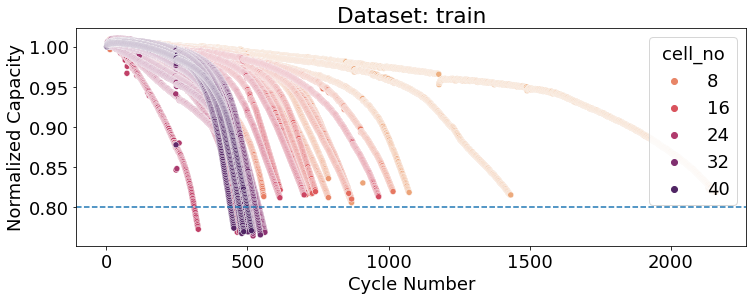

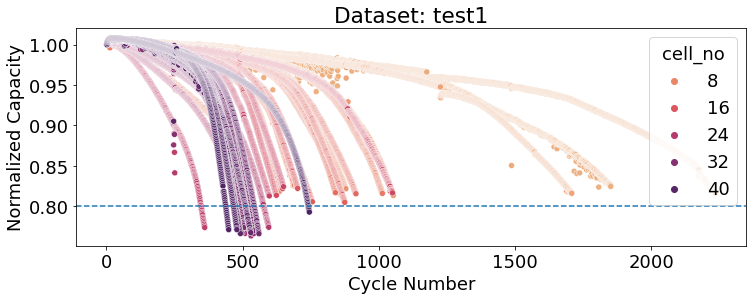

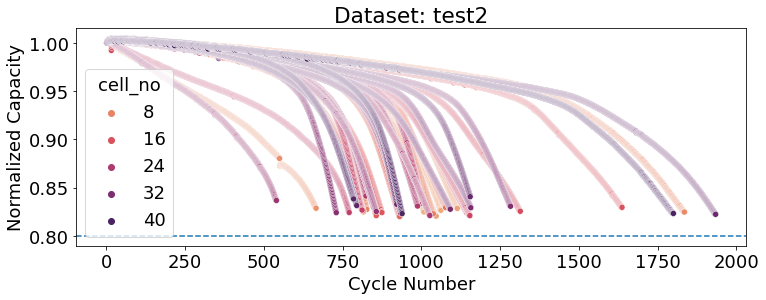

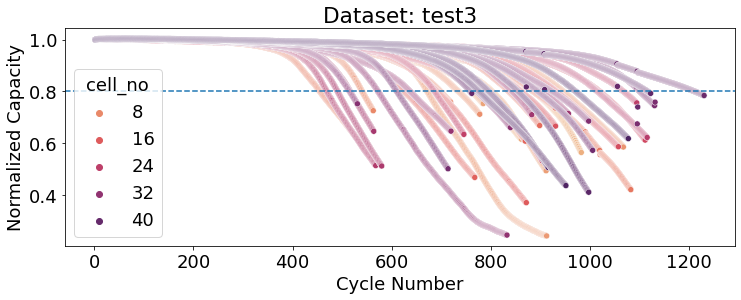

In [21]:
for myset in range(len(dataset)):
    fig = plt.figure(figsize=(12,4))
    sns.scatterplot(
        data=all_Q_curves.loc[all_Q_curves['dataset']==dataset[myset]], 
        x="cycle_no", y="norm_Q", hue="cell_no", palette="flare"
    )
    plt.axhline(0.8, linestyle='dashed')
    plt.title("Dataset: "+ dataset[myset])
    plt.xlabel("Cycle Number")
    plt.ylabel("Normalized Capacity")

## Load the VQ curve data

### We will use VQ(cycle=100)-VQ(cycle=10) as feature to determine RUL

In [22]:
VQcol_names = ["cycle_"+str(i+1) for i in range(150)]
all_VQ_curves = pd.DataFrame()
for myset in range(len(dataset)):
    for cell in range(number_cells[myset]):
        cell_VQ = pd.read_csv("Dataset/V_Q_curve/"+dataset[myset]+"/cell"+str(cell+1)+".csv", header = None,
                               names=VQcol_names)
        cell_VQ['voltage'] = np.linspace(3.5,2,cell_VQ.shape[0])
        cell_VQ['diff_cycle100_cycle10'] = cell_VQ['cycle_100']-cell_VQ['cycle_10']
        cell_VQ['cell_no'] = cell+1 # cell number
        cell_VQ['dataset'] = dataset[myset]
        all_VQ_curves = pd.concat([all_VQ_curves, cell_VQ], axis=0)

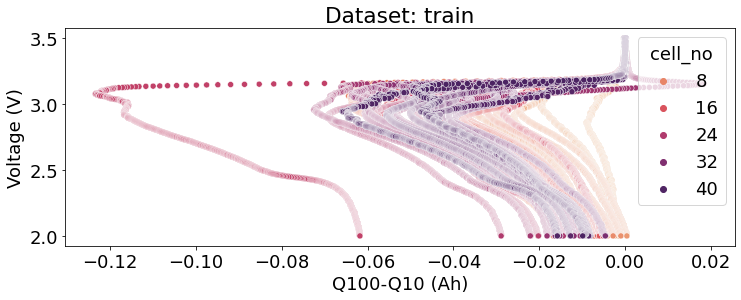

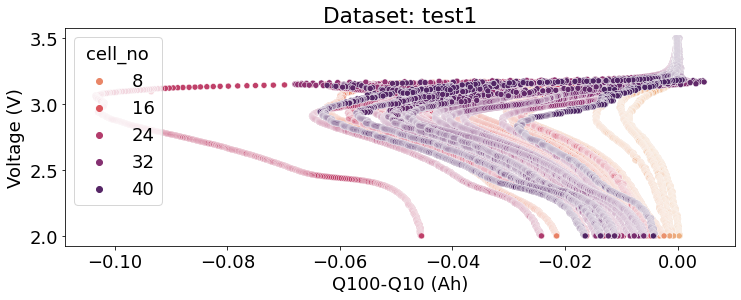

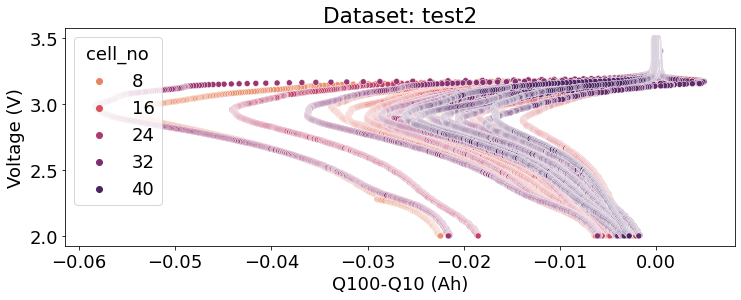

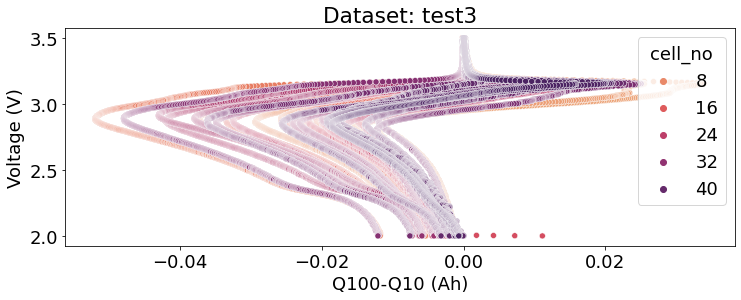

In [23]:
for myset in range(len(dataset)):
    fig = plt.figure(figsize=(12,4))
    sns.scatterplot(
        data=all_VQ_curves.loc[all_VQ_curves['dataset']==dataset[myset]], 
        x="diff_cycle100_cycle10", y="voltage", hue="cell_no", palette="flare"
    )
    plt.title("Dataset: "+ dataset[myset])
    plt.xlabel("Q100-Q10 (Ah)")
    plt.ylabel("Voltage (V)")

In [24]:
all_VQ_curves.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000295,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000259,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000225,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000193,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000163,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train


In [25]:
all_VQ_curves.groupby(by=['dataset', 'cell_no']).var().reset_index()

,dataset,cell_no,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,...,cycle_143,cycle_144,cycle_145,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10
0,test1,1,0.178752,0.179241,0.179079,0.179453,0.179358,0.179632,0.179590,0.179506,...,0.177868,0.177846,0.177759,0.177704,0.177670,0.177508,0.177683,NaN,0.188063,0.000009
1,test1,2,0.181725,0.182183,0.181989,0.182463,0.182225,0.182640,0.182494,0.182277,...,0.180655,0.180659,0.180621,0.180616,0.180548,0.180525,0.180546,NaN,0.188063,0.000011
2,test1,3,0.182167,0.182007,0.181987,0.182112,0.182336,0.182235,0.182355,0.182331,...,0.179545,0.179510,0.179463,0.179449,0.179423,0.179420,0.179379,NaN,0.188063,0.000025
3,test1,4,0.182607,0.182857,0.183438,0.183404,0.183316,0.183366,0.183376,0.183458,...,0.176391,0.176259,0.176179,0.176167,0.176036,0.176073,0.175996,NaN,0.188063,0.000169
4,test1,5,0.182917,0.183044,0.183438,0.183402,0.183329,0.183819,0.183975,0.183916,...,0.178252,0.178320,0.178365,0.178328,0.178260,0.178228,0.178179,NaN,0.188063,0.000105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,train,37,0.182196,0.182502,0.182961,0.182664,0.182682,0.183001,0.182762,0.182846,...,0.170665,0.170499,0.170139,0.170217,0.170072,0.169928,0.169949,NaN,0.188063,0.000308
164,train,38,0.183576,0.183577,0.184326,0.184238,0.184364,0.184615,0.184484,0.184521,...,0.170353,0.170470,0.170269,0.169122,0.170035,0.169658,0.169626,NaN,0.188063,0.000353
165,train,39,0.179789,0.179786,0.179393,0.180324,0.180193,0.179621,0.180416,0.180068,...,0.168280,0.168657,0.167971,0.167886,0.168248,0.167921,0.168274,NaN,0.188063,0.000207
166,train,40,0.182214,0.182752,0.182559,0.182490,0.182954,0.183030,0.183081,0.183180,...,0.167826,0.167731,0.167097,0.167074,0.167128,0.166798,0.166745,NaN,0.188063,0.000476


In [26]:
all_cycle_lives = pd.DataFrame()
for myset in range(len(dataset)):
    cycle_lives = pd.read_csv("Dataset/cycle_lives/"+dataset[myset]+"_cycle_lives.csv", header = None,
                             names=['cycle_life']).reset_index()
    cycle_lives['cell_no'] = cycle_lives['index'] + 1
    cycle_lives['dataset'] = dataset[myset]
    
    all_cycle_lives = pd.concat([all_cycle_lives, cycle_lives.drop('index', axis=1)], axis=0)

In [27]:
all_cycle_lives.head()

,cycle_life,cell_no,dataset
0,2160,1,train
1,1434,2,train
2,1074,3,train
3,870,4,train
4,788,5,train


In [28]:
all_VQ_curves_merge = pd.merge(all_VQ_curves, all_cycle_lives, how='left',
                               left_on = ['dataset', 'cell_no'], right_on = ['dataset', 'cell_no'])
all_VQ_curves_merge_agg = all_VQ_curves_merge.groupby(by=['cell_no', 'dataset']).agg({'diff_cycle100_cycle10':'var',
                                                            'cycle_life': 'mean'}).reset_index()

## Data Visualization
(similar to the Nature Energy paper)

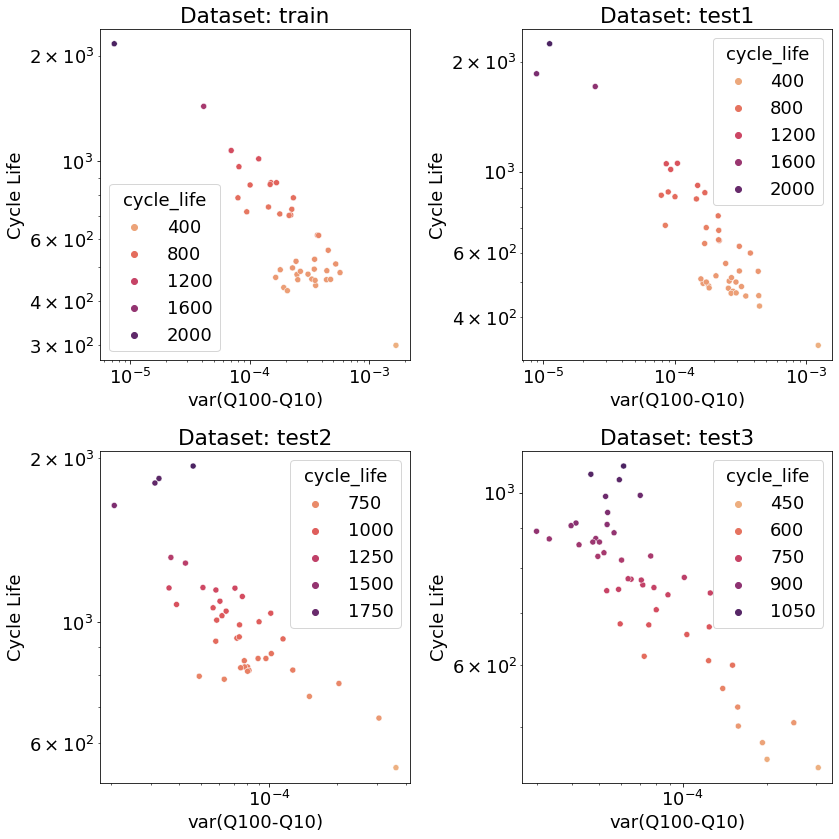

In [29]:
fig, ax = plt.subplots(2,2,figsize=(12, 12))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    sns.scatterplot(
        data=all_VQ_curves_merge_agg.loc[all_VQ_curves_merge_agg['dataset']==dataset[myset]], 
        x="diff_cycle100_cycle10", y="cycle_life", hue="cycle_life", palette="flare", ax = myax
    )
    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("var(Q100-Q10)")
    myax.set_ylabel("Cycle Life")
    myax.set_xscale('log')
    myax.set_yscale('log')
plt.tight_layout()

In [30]:
all_VQ_curves_merge.head()

,cycle_1,cycle_2,cycle_3,cycle_4,cycle_5,cycle_6,cycle_7,cycle_8,cycle_9,cycle_10,...,cycle_146,cycle_147,cycle_148,cycle_149,cycle_150,voltage,diff_cycle100_cycle10,cell_no,dataset,cycle_life
0,-0.000460,-0.000352,-0.000451,-0.000230,-0.000168,-0.000447,-0.000328,-0.000361,-0.000158,-0.000167,...,-0.000340,-0.000292,-0.000329,-0.000307,NaN,3.500000,-0.000097,1,train,2160
1,-0.000418,-0.000314,-0.000404,-0.000201,-0.000141,-0.000400,-0.000290,-0.000320,-0.000132,-0.000141,...,-0.000306,-0.000262,-0.000293,-0.000273,NaN,3.498498,-0.000092,1,train,2160
2,-0.000378,-0.000278,-0.000360,-0.000172,-0.000114,-0.000356,-0.000254,-0.000282,-0.000106,-0.000115,...,-0.000272,-0.000232,-0.000259,-0.000240,NaN,3.496997,-0.000087,1,train,2160
3,-0.000340,-0.000243,-0.000319,-0.000144,-0.000089,-0.000314,-0.000220,-0.000246,-0.000082,-0.000090,...,-0.000240,-0.000203,-0.000227,-0.000208,NaN,3.495495,-0.000082,1,train,2160
4,-0.000303,-0.000211,-0.000281,-0.000116,-0.000064,-0.000275,-0.000188,-0.000212,-0.000059,-0.000066,...,-0.000209,-0.000174,-0.000196,-0.000178,NaN,3.493994,-0.000078,1,train,2160


## Make Input-Output for training the UQ models
Input:- VQ(100)-VQ(10)

Output:- cycle life

In [31]:
def get_input_output(df, myset):
    df_myset = df.loc[df['dataset']==myset]
    X, Y = [], []
    for mycell in sorted(set(df_myset['cell_no'])):
        X.append(df_myset.loc[df_myset['cell_no']==mycell].sort_values(
            by='voltage', ascending = False, axis = 0)['diff_cycle100_cycle10'].values)
        Y.append(df_myset.loc[df_myset['cell_no']==mycell]['cycle_life'].mean())
    return X, np.expand_dims(Y, axis=1)

In [32]:
Xtrain, Ytrain = get_input_output(all_VQ_curves_merge, 'train')
Xtest1, Ytest1 = get_input_output(all_VQ_curves_merge, 'test1')
Xtest2, Ytest2 = get_input_output(all_VQ_curves_merge, 'test2')
Xtest3, Ytest3 = get_input_output(all_VQ_curves_merge, 'test3')

scalerX = MinMaxScaler()
Xtrain_norm, Ytrain_norm  = scalerX.fit_transform(Xtrain), (Ytrain)/np.max(Ytrain)
Xtest1_norm, Ytest1_norm  = scalerX.transform(Xtest1), (Ytest1)/np.max(Ytrain)
Xtest2_norm, Ytest2_norm  = scalerX.transform(Xtest2), (Ytest2)/np.max(Ytrain)
Xtest3_norm, Ytest3_norm  = scalerX.transform(Xtest3), (Ytest3)/np.max(Ytrain)

## Common functions definitions

In [33]:
# Ensembling of individual models
def get_ensemble(df, UQmodelcode, nmodels_select):
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = df[mu_cols].mean(axis=1)
    if UQmodelcode=="DE":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             + np.mean(df[sigma_cols]**2, axis = 1)
                             - mu_eff**2)
    elif UQmodelcode=="MC":
        sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                             - mu_eff**2)
    df[UQmodelcode+"_mu_eff"] = mu_eff
    df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return df

# Get calibration curves
def get_confidence_interval(y_true, mu, sigma):
    alphas = np.linspace(1e-10, 1-1e-10, 1000)
    myCI=[]
    for myalpha in sorted(alphas):
        intervals = scipy.stats.norm.interval(alpha=myalpha, loc=mu, scale=sigma)
        lower_bd = intervals[0]
        upper_bd = intervals[1]
        myCI.append(np.sum((y_true > lower_bd) & (y_true < upper_bd))/len(y_true))
    
    return 100*alphas, 100*np.array(myCI)  # converting to percentages

## Uncertainty Model 1: Deep Ensemble (DE)

- Use of Gaussian Layer that outputs - mean and aleatoric variance
- Use of Negative Log Likelihood loss
- Ensemble to capture epistematic uncertainty

In [34]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((sigma)) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), (sigma))) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]

In [35]:
def generate_trained_DEmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dense(10, activation = actfn)(x)
      
    mu, sigma = GaussianLayer(1, name='main_output')(x)
    model = Model(feature_input, mu)
    model.compile(loss=custom_loss(sigma), optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate

In [36]:
# First let us do a single run
# Create 10 models and select some based on training error
prediction_fns, train_mae = [], []
nmodels = 10
nepochs = 300

pbar=ProgressBar()
for i in pbar(range(nmodels)):
    my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
    train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
    prediction_fns.append(my_func)
    
nmodels_select = 5
final_DE_fns = []
for i in range(nmodels_select):
    final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])

100% |#########################################################################|


In [37]:
allresults_df = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nmodels_select):
        result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
        result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

    result_df = get_ensemble(result_df, "DE", nmodels_select)
    allresults_df = pd.concat([allresults_df, result_df], axis = 0)
allresults_df.head()

,True,dataset,DE_mu_0,DE_sigma_0,DE_mu_1,DE_sigma_1,DE_mu_2,DE_sigma_2,DE_mu_3,DE_sigma_3,DE_mu_4,DE_sigma_4,DE_mu_eff,DE_sigma_eff
0,2160.0,train,1938.710083,220.667831,1827.328125,171.628479,1826.938599,326.578094,2001.256104,217.831085,1739.058105,189.933472,1866.658203,249.417328
1,1434.0,train,1449.680542,175.535889,1346.900757,146.081604,1395.179199,233.488617,1421.234619,217.935532,1358.025513,191.102753,1394.204102,199.018524
2,1074.0,train,1080.123901,150.579468,927.243591,124.568649,981.649109,173.013077,1108.636230,218.134140,1041.645264,192.953354,1027.859619,186.892685
3,870.0,train,805.127747,131.454391,727.908081,114.865791,786.701843,151.205185,855.066895,218.409195,867.402100,193.923172,808.441345,173.934250
4,788.0,train,975.260742,141.190445,847.291565,116.556755,1003.170532,178.005630,1116.700806,218.534744,1122.770752,193.640549,1013.038879,201.118744


## Results - Visualization

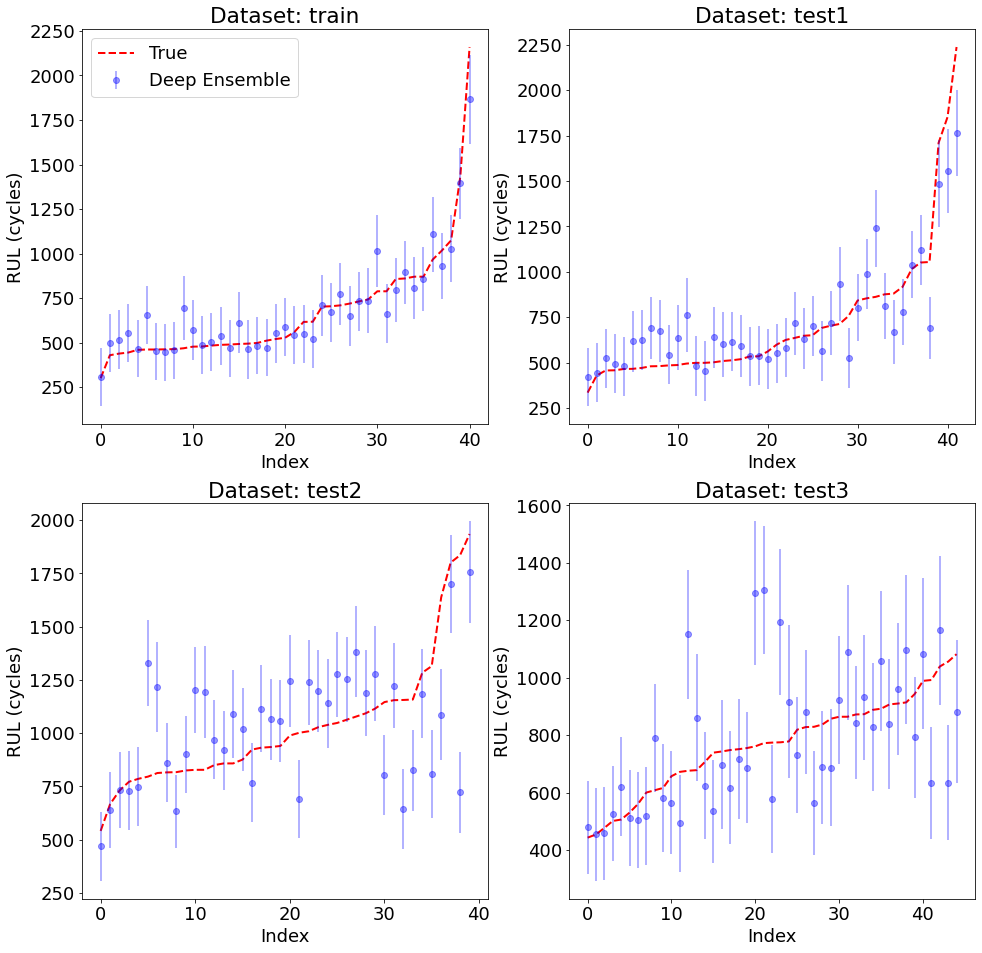

In [38]:
allresults_df_sorted = allresults_df.sort_values(by='True', ascending=True)
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_df_sorted.loc[allresults_df_sorted['dataset']==dataset[myset]]
    myax.plot(range(df.shape[0]), df['True'], 
             color='red', linestyle='dashed', linewidth=2, label='True')
    myax.errorbar(range(df.shape[0]), df['DE_mu_eff'], 
                 yerr = df['DE_sigma_eff'],
                 fmt='o', color='blue', alpha = 0.4, label='Deep Ensemble')
    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Index")
    myax.set_ylabel("RUL (cycles)")
    if myset ==0:
        myax.legend()

In [39]:
allresults_df_sorted.head()

,True,dataset,DE_mu_0,DE_sigma_0,DE_mu_1,DE_sigma_1,DE_mu_2,DE_sigma_2,DE_mu_3,DE_sigma_3,DE_mu_4,DE_sigma_4,DE_mu_eff,DE_sigma_eff
20,300.0,train,287.311462,114.120972,326.134674,113.945213,318.050079,131.106812,316.775940,227.572952,279.944397,195.694260,305.643311,164.302200
21,335.0,test1,423.199799,111.865578,452.307465,104.126358,453.793213,128.620789,394.349213,218.906647,381.480865,196.878036,421.026123,161.810364
38,429.0,train,442.457367,116.806152,486.254333,105.087395,498.565918,132.320786,559.912354,218.591248,497.344574,197.206879,496.906891,164.875473
40,429.0,test1,424.803467,112.844040,465.395020,104.147324,448.472382,130.386490,455.203857,218.798782,433.130035,197.691635,445.400970,160.384506
21,438.0,train,459.862549,116.196144,495.600372,105.342812,504.117462,132.680496,566.823792,218.614273,550.481140,196.406006,515.377075,164.954071


In [40]:
alphas, CI_DE = get_confidence_interval(allresults_df_sorted['True'].values, 
                                       allresults_df_sorted['DE_mu_eff'].values, 
                                       allresults_df_sorted['DE_sigma_eff'].values)

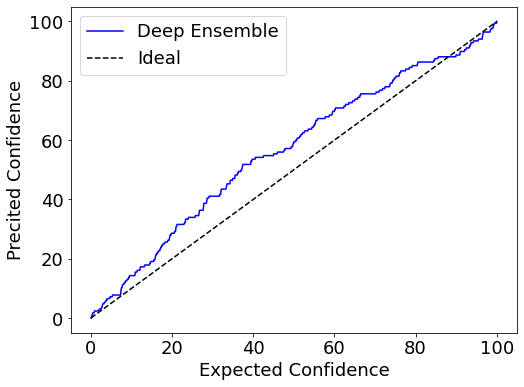

In [41]:
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='Deep Ensemble')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

## Repeat the above algorithm for 10 times to capture variations

In [42]:
model_train_bool = False

if model_train_bool:
    ## Multiple runs
    niter = 10
    allCI_DE = np.zeros((1000, niter))
    pbar=ProgressBar()

    allresults_DEdf = pd.DataFrame()
    for myiter in pbar(range(niter)):
        prediction_fns=[]
        train_mae=[]
        for i in range(nmodels):
            my_func = generate_trained_DEmodel(Xtrain_norm, Ytrain_norm, nepochs, actfn = 'tanh')
            train_mae.append(mae(Ytrain, (my_func(Xtrain_norm)[0])*np.max(Ytrain)))
            prediction_fns.append(my_func)

        nmodels_select = 5
        final_DE_fns = []
        for i in range(nmodels_select):
            final_DE_fns.append(prediction_fns[np.argsort(train_mae)[:nmodels_select][i]])


        for myset in dataset:
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in range(nmodels_select):
                result_df["DE_mu_"+str(i)] = (final_DE_fns[i](Xnorm)[0])*np.max(Ytrain)
                result_df["DE_sigma_"+str(i)] = (np.sqrt(final_DE_fns[i](Xnorm)[1]))*np.max(Ytrain)

            result_df = get_ensemble(result_df, "DE", nmodels_select)
            result_df['iteration'] = myiter
            allresults_DEdf = pd.concat([allresults_DEdf, result_df], axis = 0)
    allresults_DEdf.to_excel("DeepEnsemble_battery_prediction_results.xlsx")  
else:
    allresults_DEdf=pd.read_excel("DeepEnsemble_battery_prediction_results.xlsx")  

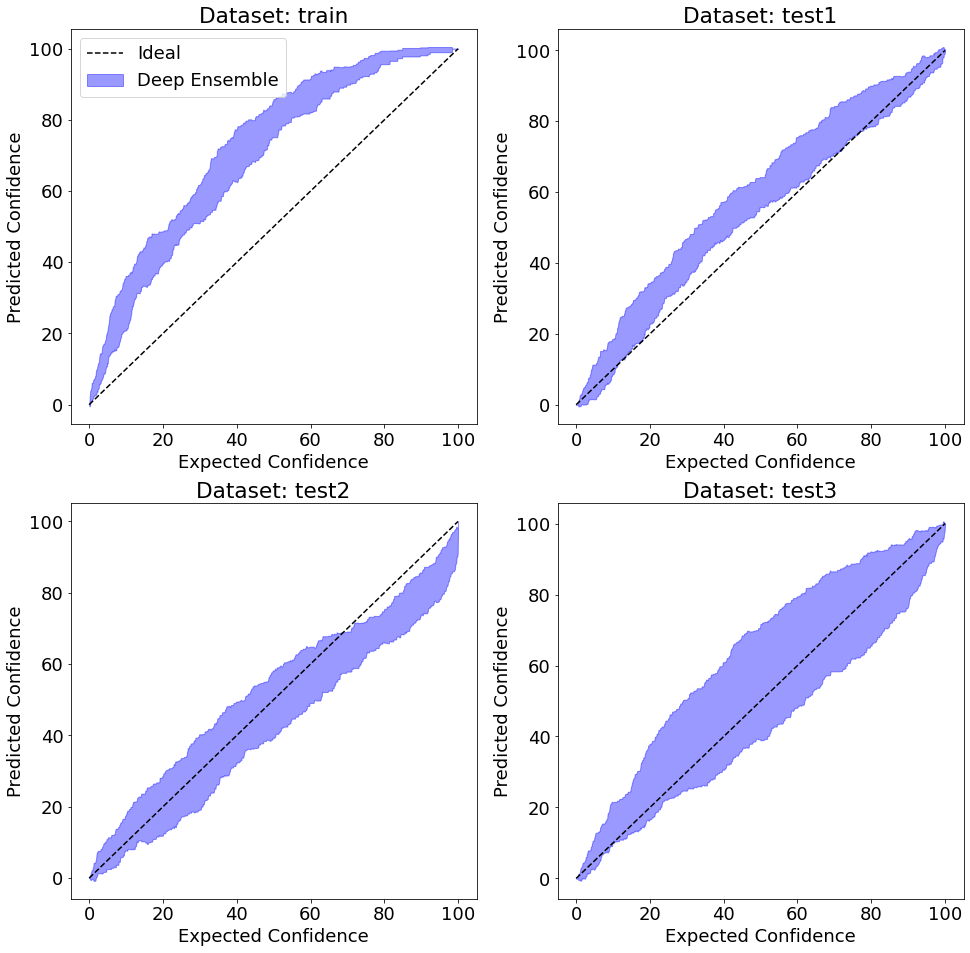

In [43]:
niter = len(set(allresults_DEdf['iteration']))
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_DE = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_DEdf.loc[(allresults_DEdf['dataset']==dataset[myset]) & 
                                 (allresults_DEdf['iteration']==myiter)]
        alphas, CI_DE = get_confidence_interval(df['True'].values, 
                                               df['DE_mu_eff'].values, 
                                               df['DE_sigma_eff'].values)
        allCI_DE[:,myiter] = CI_DE
        
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.fill_between(alphas,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()
        

## UQ Model: MC Dropout

Simple MLP architecture with 10% dropout probability

In [44]:
def generate_trained_MCmodel(trainX, trainY, nepochs, actfn = 'sigmoid'):

    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(100, activation = actfn)(feature_input)
    x = Dropout(rate = 0.10)(x)
    x = Dense(10, activation = actfn)(x)
    x = Dropout(rate = 0.10)(x)
    mu = Dense(1, activation = actfn)(x)

    model = Model(feature_input, mu)
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY,shuffle=True, epochs=nepochs, verbose = 0)

    return model

In [45]:
# Single run through
nmodels = 3 # train models and select the best out of these
all_models_MC=[]
all_mae_train_MC = np.zeros(nmodels,)
pbar = ProgressBar()
for i in pbar(range(nmodels)):
    model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 3000, 'sigmoid')
    all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
    all_models_MC.append(model_MC)

100% |#########################################################################|


In [46]:
select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)]
print("Train MAE: ", mae(K.get_value(select_modelMC(Xtrain_norm))*(np.max(Ytrain)), Ytrain))
print("Test1 MAE: ", mae(K.get_value(select_modelMC(Xtest1_norm))*(np.max(Ytrain)), Ytest1))
print("Test2 MAE: ", mae(K.get_value(select_modelMC(Xtest2_norm))*(np.max(Ytrain)), Ytest2))
print("Test3 MAE: ", mae(K.get_value(select_modelMC(Xtest3_norm))*(np.max(Ytrain)), Ytest3))

Train MAE:  32.886087557164636
Test1 MAE:  106.74000331333706
Test2 MAE:  269.70532608032227
Test3 MAE:  265.4355041503906


In [47]:
# Obtain the RUL prediction results for multiple runs
nmodel_runs = 5
allresults_MCdf = pd.DataFrame()
for myset in dataset:
    exec("Xnorm =X"+myset+"_norm")
    exec("Y =Y"+myset)

    result_df = pd.DataFrame(Y, columns = ['True'])
    result_df['dataset'] = myset
    for i in range(nmodel_runs):
        result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

    allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodel_runs)

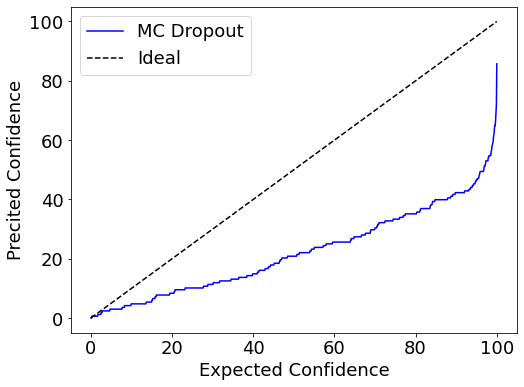

In [48]:
# plot the calibration curve
alphas, CI_DE = get_confidence_interval(allresults_MCdf['True'].values, 
                                       allresults_MCdf['MC_mu_eff'].values, 
                                       allresults_MCdf['MC_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_DE, color = 'blue', label='MC Dropout')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

In [49]:
model_train_bool = False
if model_train_bool:
    nmodels = 3 # total models trained and best one picked
    nmodel_runs = 5 # run 5 times per each select model with dropout
    niter = 10

    allCI_MC = np.zeros((1000, niter))
    pbar=ProgressBar()
    allresults_MCdf = pd.DataFrame()

    for myiter in pbar(range(niter)): # for each independent iteration
        all_models_MC=[]
        all_mae_train_MC = np.zeros(nmodels,)
        pbar = ProgressBar()
        for i in range(nmodels): # train multiple models to select the best
            model_MC = generate_trained_MCmodel(Xtrain_norm, Ytrain_norm, 3000, 'sigmoid')
            all_mae_train_MC[i] = mae(K.get_value(model_MC(Xtrain_norm))*(np.max(Ytrain)), Ytrain)
            all_models_MC.append(model_MC)

        select_modelMC = all_models_MC[np.argmin(all_mae_train_MC)] # best model

        for myset in dataset: # execute the model for all the datasets
            exec("Xnorm =X"+myset+"_norm")
            exec("Y =Y"+myset)

            result_df = pd.DataFrame(Y, columns = ['True'])
            result_df['dataset'] = myset
            for i in range(nmodel_runs): # run the best model multiple times with dropout enabled
                result_df["MC_mu_"+str(i)] = K.get_value(select_modelMC(Xnorm, training=True))*(np.max(Ytrain))

            result_df['iteration'] = myiter
            allresults_MCdf = pd.concat([allresults_MCdf, result_df], axis = 0)
        allresults_MCdf = get_ensemble(allresults_MCdf, "MC", nmodel_runs)
    allresults_MCdf.to_excel("MCDropout_battery_prediction_results.xlsx")  
else:
    allresults_MCdf=pd.read_excel("MCDropout_battery_prediction_results.xlsx")  

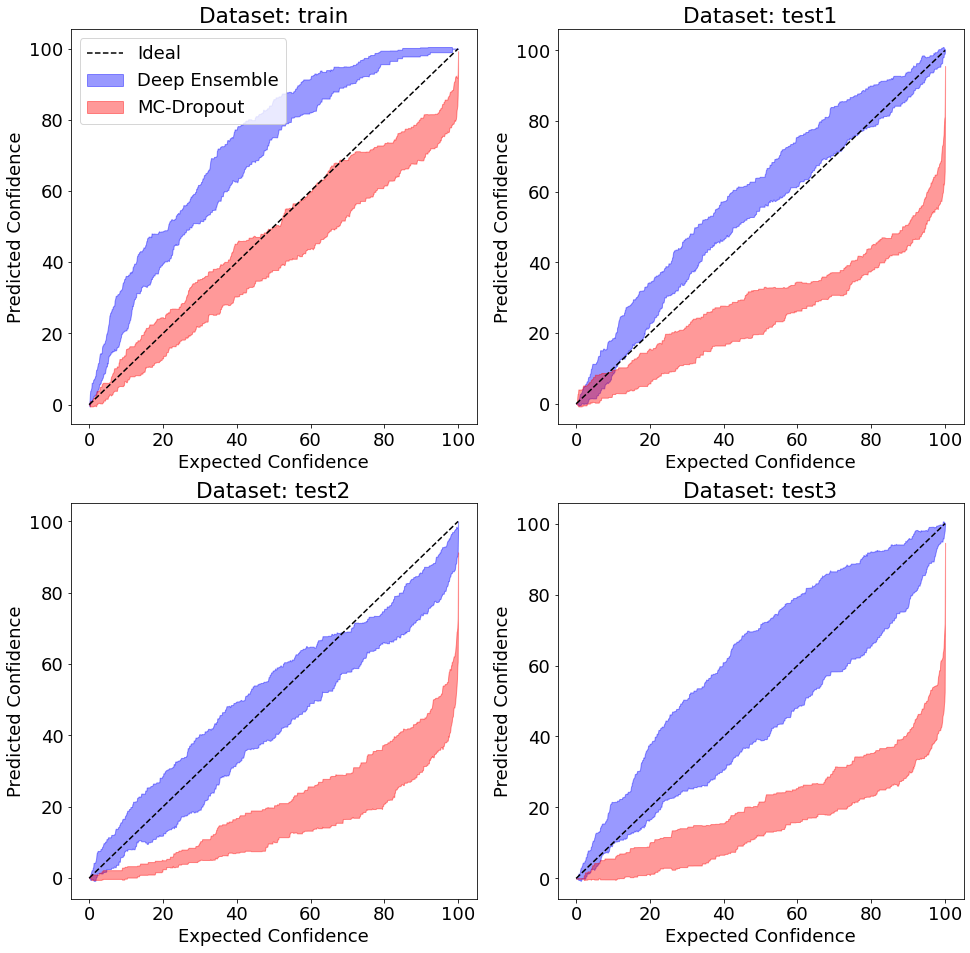

In [50]:
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_DE = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    for myiter in range(niter):
        # MC dropout
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        alphas, CI_MC = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        # Deep Ensemble
        df = allresults_DEdf.loc[(allresults_DEdf['dataset']==dataset[myset]) & 
                                 (allresults_DEdf['iteration']==myiter)]
        alphas, CI_DE = get_confidence_interval(df['True'].values, 
                                               df['DE_mu_eff'].values, 
                                               df['DE_sigma_eff'].values)
        allCI_DE[:,myiter] = CI_DE
        
        
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.fill_between(alphas,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
    
    myax.fill_between(alphas,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

# Gaussian Process Regression

In [51]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

model_GP = GaussianProcessRegressor(kernel=1 * RBF(length_scale=2.0, length_scale_bounds=(1e-2, 1e2)), 
                                            n_restarts_optimizer=9)
model_GP.fit(Xtrain_norm, Ytrain_norm)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=2),
                         n_restarts_optimizer=9)

In [52]:
print("Train MAE: ", mae(model_GP.predict(Xtrain_norm, return_std=True)[0]*(np.max(Ytrain)), Ytrain))
print("Test1 MAE: ", mae(model_GP.predict(Xtest1_norm, return_std=True)[0]*(np.max(Ytrain)), Ytest1))
print("Test2 MAE: ", mae(model_GP.predict(Xtest2_norm, return_std=True)[0]*(np.max(Ytrain)), Ytest2))
print("Test3 MAE: ", mae(model_GP.predict(Xtest3_norm, return_std=True)[0]*(np.max(Ytrain)), Ytest3))

Train MAE:  4.664095227759034e-06
Test1 MAE:  105.97984484266661
Test2 MAE:  204.26372660660164
Test3 MAE:  320.09614560136197


In [53]:
model_train_bool = False
if model_train_bool:
    allresults_GPdf = pd.DataFrame()
    for myset in dataset:
        exec("Xnorm =X"+myset+"_norm")
        exec("Y =Y"+myset)

        result_df = pd.DataFrame(Y, columns = ['True'])
        result_df['dataset'] = myset
        result_df["GP_mu_eff"], result_df["GP_sigma_eff"] = model_GP.predict(Xnorm, return_std=True)
        allresults_GPdf = pd.concat([allresults_GPdf, result_df], axis = 0)

    allresults_GPdf["GP_mu_eff"] = allresults_GPdf["GP_mu_eff"]*(np.max(Ytrain))
    allresults_GPdf["GP_sigma_eff"] = allresults_GPdf["GP_sigma_eff"]*(np.max(Ytrain))
    allresults_GPdf.to_excel("GPR_battery_prediction_results.xlsx")
else:
    allresults_GPdf=pd.read_excel("GPR_battery_prediction_results.xlsx")

In [54]:
allresults_GPdf.head()

,Unnamed: 0,True,dataset,GP_mu_eff,GP_sigma_eff
0,0,2160,train,2159.999995,0.0216
1,1,1434,train,1433.999996,0.0216
2,2,1074,train,1074.000009,0.0216
3,3,870,train,869.999991,0.0216
4,4,788,train,788.000011,0.0216


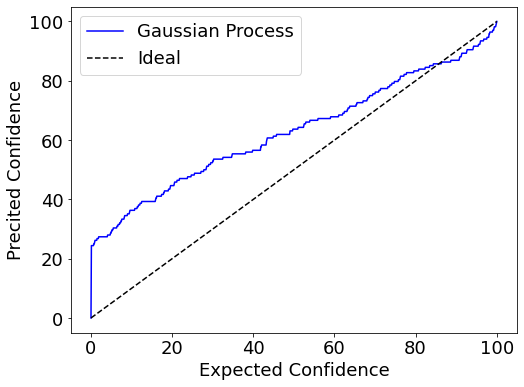

In [55]:
alphas, CI_GP = get_confidence_interval(allresults_GPdf['True'].values, 
                                       allresults_GPdf['GP_mu_eff'].values, 
                                       allresults_GPdf['GP_sigma_eff'].values)
fig = plt.figure(figsize=(8,6))
plt.plot(alphas,CI_GP, color = 'blue', label='Gaussian Process')
plt.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
plt.xlabel('Expected Confidence')
plt.ylabel('Precited Confidence')
plt.legend()

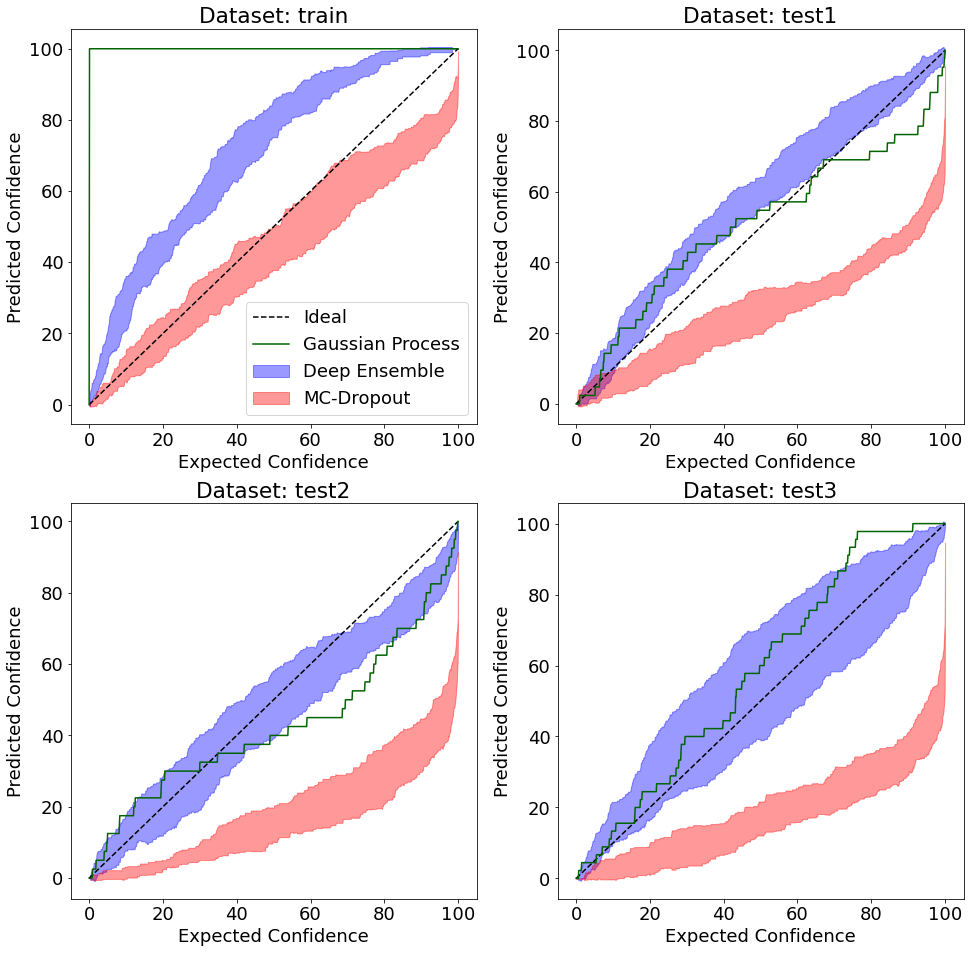

In [56]:
# plot GPR - there is no run to run variation here. 
fig, ax = plt.subplots(2,2,figsize=(16, 16))
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_GPdf.loc[allresults_GPdf['dataset']==dataset[myset]]
    
    alphas, CI_GP = get_confidence_interval(df['True'].values, 
                                           df['GP_mu_eff'].values, 
                                           df['GP_sigma_eff'].values)
    
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.plot(alphas,CI_GP, color = 'darkgreen', label='Gaussian Process')
    

    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

# plotting DE and MC
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_DE = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        alphas, CI_MC = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        df = allresults_DEdf.loc[(allresults_DEdf['dataset']==dataset[myset]) & 
                                 (allresults_DEdf['iteration']==myiter)]
        alphas, CI_DE = get_confidence_interval(df['True'].values, 
                                               df['DE_mu_eff'].values, 
                                               df['DE_sigma_eff'].values)
        allCI_DE[:,myiter] = CI_DE
        
        
    myax.fill_between(alphas,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
    
    myax.fill_between(alphas,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()

## SNGP

distance-aware based

 - spectral normalization from keras layers
 - gaussian process from gpflow, gpflux libraries

(inspiration from https://secondmind-labs.github.io/GPflux/notebooks/gpflux_with_keras_layers.html and https://www.tensorflow.org/tutorials/understanding/sngp)

Please run the other notebook titled `UQ_models_train_evaluate_FinalSNGP`

In [76]:
allresults_SNGPdf=pd.read_excel("SNGP_battery_prediction_results.xlsx")

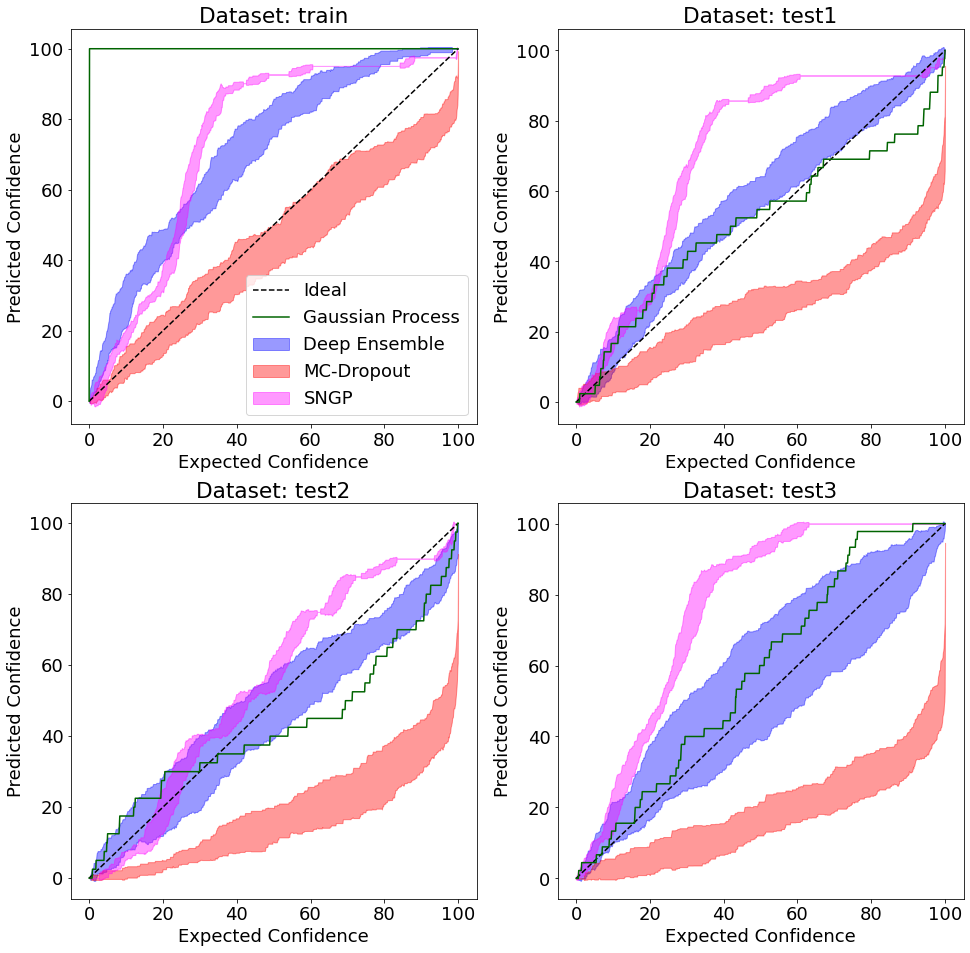

In [77]:
fig, ax = plt.subplots(2,2,figsize=(16, 16))

# plot GPR - there is no run to run variation here. 
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    df = allresults_GPdf.loc[allresults_GPdf['dataset']==dataset[myset]]
    
    alphas, CI_GP = get_confidence_interval(df['True'].values, 
                                           df['GP_mu_eff'].values, 
                                           df['GP_sigma_eff'].values)
    
    myax.plot([0,100],[0,100], color='black', linestyle='dashed', label='Ideal')
    myax.plot(alphas,CI_GP, color = 'darkgreen', label='Gaussian Process')


# plotting DE and MC
for myset, myax in zip(range(len(dataset)),ax.flatten()):
    
    allCI_DE = np.zeros((1000, niter))
    allCI_MC = np.zeros((1000, niter))
    allCI_SNGP = np.zeros((1000, niter))
    for myiter in range(niter):
        df = allresults_MCdf.loc[(allresults_MCdf['dataset']==dataset[myset]) & 
                                 (allresults_MCdf['iteration']==myiter)]
        alphas, CI_MC = get_confidence_interval(df['True'].values, 
                                               df['MC_mu_eff'].values, 
                                               df['MC_sigma_eff'].values)
        allCI_MC[:,myiter] = CI_MC
        
        df = allresults_DEdf.loc[(allresults_DEdf['dataset']==dataset[myset]) & 
                                 (allresults_DEdf['iteration']==myiter)]
        alphas, CI_DE = get_confidence_interval(df['True'].values, 
                                               df['DE_mu_eff'].values, 
                                               df['DE_sigma_eff'].values)
        allCI_DE[:,myiter] = CI_DE
        
        df = allresults_SNGPdf.loc[(allresults_SNGPdf['dataset']==dataset[myset]) & 
                                 (allresults_SNGPdf['iteration']==myiter)]
        alphas, CI_SNGP = get_confidence_interval(df['True'].values, 
                                               df['SNGP_mu_eff'].values, 
                                               df['SNGP_sigma_eff'].values)
        allCI_SNGP[:,myiter] = CI_SNGP
        
        
    myax.fill_between(alphas,
                np.mean(allCI_DE, axis = 1)+np.std(allCI_DE, axis = 1),
                np.mean(allCI_DE, axis = 1)-np.std(allCI_DE, axis = 1),
                color='blue', alpha = 0.4, linestyle='None', label='Deep Ensemble')
    
    myax.fill_between(alphas,
                np.mean(allCI_MC, axis = 1)+np.std(allCI_MC, axis = 1),
                np.mean(allCI_MC, axis = 1)-np.std(allCI_MC, axis = 1),
                color='red', alpha = 0.4, linestyle='None', label='MC-Dropout')
    
    myax.fill_between(alphas,
                np.mean(allCI_SNGP, axis = 1)+np.std(allCI_SNGP, axis = 1),
                np.mean(allCI_SNGP, axis = 1)-np.std(allCI_SNGP, axis = 1),
                color='magenta', alpha = 0.4, linestyle='None', label='SNGP')


    myax.set_title("Dataset: "+ dataset[myset])
    myax.set_xlabel("Expected Confidence")
    myax.set_ylabel("Predicted Confidence")
    if myset ==0:
        myax.legend()